Simple FPOP implementation in python 

From the paper:
On optimal multiple changepoint algorithms for large data
Robert Maidstone et al. Stat Comput. 2017.

Ideas taken from https://github.com/kesward/FOCuS

In [1]:
import numpy as np
import portion as p
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
class Quadratic:
    def __init__(self, a, b, c, tau, D):
        self.a = a
        self.b = b
        self.c = c
        self.tau = tau
        self.set = D
        
    def update(self, x):
        self.a += 1
        self.b -= 2*x
        self.c += x**2
    
    def evaluate(self, x):
        return self.a * x**2 + self.b * x + self.c
    
    def disc(self, z):
        return self.b**2 - 4*self.a*(self.c-z)
    
    def roots(self, z):
        disc = np.sqrt(self.b**2 - 4*self.a*(self.c-z))
        x1 = (-self.b + disc)/(2*self.a)
        x2 = (-self.b - disc)/(2*self.a)
        return p.closed(min(x1,x2), max(x1,x2))
    
    def min(self):
        return -(self.b**2)/(4*self.a) + self.c
    
    def __repr__(self):
        return f'Quadratic: {self.a}x^2 + {self.b}x + {self.c}, tau = {self.tau}'

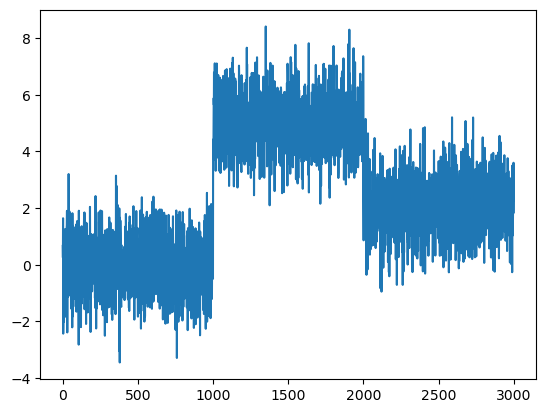

In [3]:
# sim data
X = np.concatenate((np.random.normal(size=1000), np.random.normal(size=1000) + 5, np.random.normal(size=1000) + 2))
plt.plot(X)

In [4]:
# initialise 
n = len(X)
beta = 2*np.log(n)

# optimal values
F = [None]*(n+1)
chpts = [None]*(n+1)
chpts[0] = 0
F[0] = -beta
# range for mu
D = p.closed(min(X),max(X))

cost_list = [Quadratic(0,0,0,0,D)]

In [5]:
for t in range(1, n+1):
    # update costs with observation
    for cost in cost_list:
        cost.update(x = X[(t-1)])
    tau, F[t] = min([(cost.tau, cost.min()) for cost in cost_list], key = lambda t: t[1])
    chpts[t] = tau

    new_cost_list = []
    # update sets
    I_union = p.empty()
    for cost in cost_list:
        # I_t^tau
        It_tau = cost.roots(F[t] + beta)
        # then update Set_t^tau = Set_t-1^tau n I_t^tau
        cost.set = cost.set.intersection(It_tau)
        if not cost.set.empty:
            new_cost_list.append(cost)
        # Store I intervals to do Set_t^t
        I_union = I_union.union(It_tau)

    # check if t can be pruned right away
    set_tt = D.difference(I_union)
    if not set_tt.empty:
        new_cost_list.append(Quadratic(0, 0, F[t] + beta, t, set_tt))
    cost_list = new_cost_list

/tmp/ipykernel_22796/2926385483.py:21: RuntimeWarning: invalid value encountered in sqrt
  disc = np.sqrt(self.b**2 - 4*self.a*(self.c-z))


In [6]:
# get changepoints
CP = []
last = chpts[n]
CP.append(last)
while last > 0:
    last = chpts[last]
    CP.append(last)
CP.sort()
print(CP)

[0, 1000, 2000]


In [7]:
# look at quadratics at final time step
cost_list

[Quadratic: 1000x^2 + -4109.542500010545x + 7386.147160431338, tau = 2000,
 Quadratic: 29x^2 + -93.95026274746715x + 3250.516997531752, tau = 2971,
 Quadratic: 18x^2 + -56.999774719950764x + 3221.125643961312, tau = 2982,
 Quadratic: 4x^2 + -20.80953178975036x + 3205.9406974201447, tau = 2996,
 Quadratic: 2x^2 + -11.765326433571584x + 3195.8027401837503, tau = 2998,
 Quadratic: 0x^2 + 0x + 3180.0750057184086, tau = 3000]

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_22796/1438143243.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$\mu$')


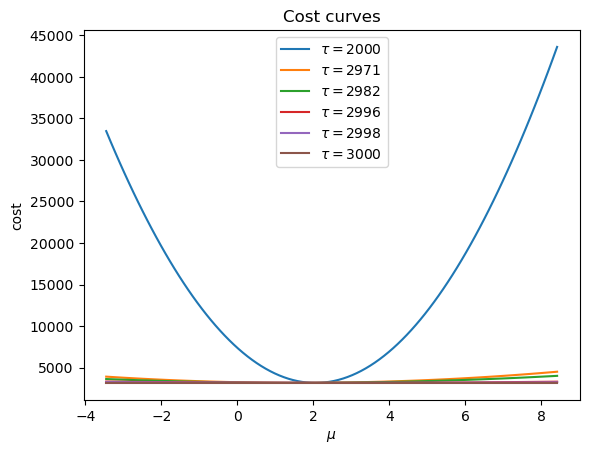

In [8]:
# plot curves
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Cost curves')

ax.set_xlabel('$\mu$')
ax.set_ylabel('cost')

mu = np.linspace(D.lower, D.upper, 100)
for q in cost_list:
    ax.plot(mu, q.evaluate(mu), label=f'$\\tau={q.tau}$')

if cost_list:
    ax.legend()